In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import os
import sys
import time

In [3]:
sys.path.append("/home/caleml/main-pe/")

In [4]:
from data.datasets.mpii import MpiiSinglePerson
from data.utils.data_utils import TEST_MODE, TRAIN_MODE, VALID_MODE
from data.loader import BatchLoader

In [5]:
from model import config
from model import callbacks
from model.utils import pose_format

In [6]:
from experiments.common import exp_init

In [7]:
# for custom objects
from model.activations import channel_softmax_2d
from model.losses import reconstruction_loss, pose_loss

## datasets

In [8]:
conf = {
    'pose_blocks': 2,
    'batch_size': 16,
    'dim': 2,
    'n_joints': 16,
    'dataset_name': 'mpii',
    'n_epochs': 2
}

In [9]:
mpii_path = '/home/caleml/datasets/mpii'
mpii = MpiiSinglePerson(mpii_path, dataconf=config.mpii_dataconf)

In [10]:
data_tr_mpii = BatchLoader(mpii,
                           ['frame'],
                           ['frame'] + ['pose'] * conf['pose_blocks'],
                           TRAIN_MODE,
                           batch_size=conf['batch_size'],
                           shuffle=False)

y_dict ['frame', 'pose', 'pose'], allkeys ['frame', 'frame', 'pose', 'pose']


In [11]:
mpii_eval = MpiiSinglePerson(mpii_path, dataconf=config.mpii_dataconf)
data_val_mpii = BatchLoader(
    mpii_eval, 
    ['frame'], 
    ['frame', 'pose', 'afmat', 'headsize'], 
    mode=VALID_MODE,
    shuffle=False)

len(data_val_mpii)

y_dict ['frame', 'pose', 'afmat', 'headsize'], allkeys ['frame', 'frame', 'pose', 'afmat', 'headsize']


124

# 1. old 2D model

In [12]:
from model.networks.old_mbm import MultiBranchModel
model = MultiBranchModel(dim=conf['dim'], nb_pose_blocks=conf['pose_blocks'])
model.build()

/home/caleml/.local/lib/python3.4/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


pose shape (?, 16, 2), vis shape (?, 16, 1), concat shape (?, 16, 3)
pose shape (?, 16, 2), vis shape (?, 16, 1), concat shape (?, 16, 3)
Build E_a 12.240926742553711, build E_p 8.77576732635498, decoder D 1.4355275630950928
Input shape (?, 256, 256, 3)
Shape concat (?, 8, 8, 2048)
Outputs shape [(None, 256, 256, 3), (None, 16, 3), (None, 16, 3)]
rec y_pred shape (?, 256, 256, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
appearance_model (Model)        (None, 8, 8, 2048)   23587712    input_14[0][0]                   
__________________________________________________________________________________________________
decoder (Model)        

In [15]:
conf['exp_type'] = '2d_OLD_MBM_SAVE_TEST_NB'
model_folder = exp_init(conf)

Conducting experiment for 2 epochs and 2 blocks in folder /home/caleml/pe_experiments/exp_20190513_1821_2d_OLD_MBM_SAVE_TEST_NB__2b_bs16


In [14]:
from model import callbacks
cb_list = []
cb_list.append(callbacks.SaveModel(model_folder))
model.train(data_tr_mpii, steps_per_epoch=10, model_folder=model_folder, n_epochs=2, cb_list=cb_list)

Training with 1 callbacks
Epoch 1/2
 9/10 [==========================>...] - ETA: 4s - loss: 36.0758 - decoder_loss: 29.4199 - model_2_loss: 3.3535
Trying to save model @epoch=001 to /home/caleml/pe_experiments/exp_20190513_1820_2d_OLD_MBM_SAVE_TEST_NB__2b_bs16/model_001.h5
10/10 [==============================] - 41s 4s/step - loss: 35.3470 - decoder_loss: 28.7832 - model_2_loss: 3.2952
Epoch 2/2
 9/10 [==========================>...] - ETA: 0s - loss: 26.8249 - decoder_loss: 22.1396 - model_2_loss: 2.3425
Trying to save model @epoch=002 to /home/caleml/pe_experiments/exp_20190513_1820_2d_OLD_MBM_SAVE_TEST_NB__2b_bs16/model_002.h5
10/10 [==============================] - 6s 632ms/step - loss: 26.3204 - decoder_loss: 21.6842 - model_2_loss: 2.3152


In [ ]:
# load

In [16]:
checkpoint = "/home/caleml/pe_experiments/exp_20190513_1707_2d_OLD_MBM_SAVE_TEST_NB__2b_bs16/model_001.h5"

custom_objects = {
    '_channel_softmax_2d': channel_softmax_2d(),
    '_rec_loss': reconstruction_loss(),
    '_pose_loss': pose_loss()
}

In [17]:
eval_model = MultiBranchModel(dim=conf['dim'], nb_pose_blocks=conf['pose_blocks'])
eval_model.load(checkpoint, custom_objects=custom_objects)

rec y_pred shape (?, 256, 256, 3)


# 2. New MBM

In [ ]:
conf['exp_type'] = '2d_NEW_MBM_SAVE_TEST_NB'
model_folder = exp_init(conf)

In [ ]:
from model.networks.multi_branch_model import MultiBranchModel
model = MultiBranchModel(dim=conf['dim'], n_joints=conf['n_joints'], nb_pose_blocks=conf['pose_blocks'])
model.build()

In [ ]:
from model import callbacks
cb_list = []
cb_list.append(callbacks.SaveModel(model_folder))

In [ ]:
model.train(data_tr_mpii, steps_per_epoch=10, model_folder=model_folder, n_epochs=2, cb_list=cb_list)

In [ ]:
# load

In [ ]:
checkpoint_path = '/home/caleml/pe_experiments/exp_20190513_1604_2d_NEW_MBM_SAVE_TEST_NB__2b_bs16/model_001.h5'
custom_objects = {
    '_channel_softmax_2d': channel_softmax_2d(),
    '_rec_loss': reconstruction_loss(),
    '_pose_loss': pose_loss()
}

In [ ]:
from model.networks.multi_branch_model import MultiBranchModel
eval_model = MultiBranchModel(dim=conf['dim'], n_joints=conf['n_joints'], nb_pose_blocks=conf['pose_blocks'])
eval_model.load(checkpoint_path, custom_objects=custom_objects)

# 3. Eval

In [18]:
data = data_val_mpii.get_data(1, VALID_MODE)
print(data['frame'].shape)
pred = eval_model.predict(data['frame'])

[autoreload of tensorflow.python.keras.layers.core failed: Traceback (most recent call last):
  File "/usr/lib/python3.4/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3.4/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/usr/lib64/python3.4/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib64/python3.4/importlib/__init__.py", line 130, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module model.networks.old_pose not in sys.modules
]


(24, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

24
24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

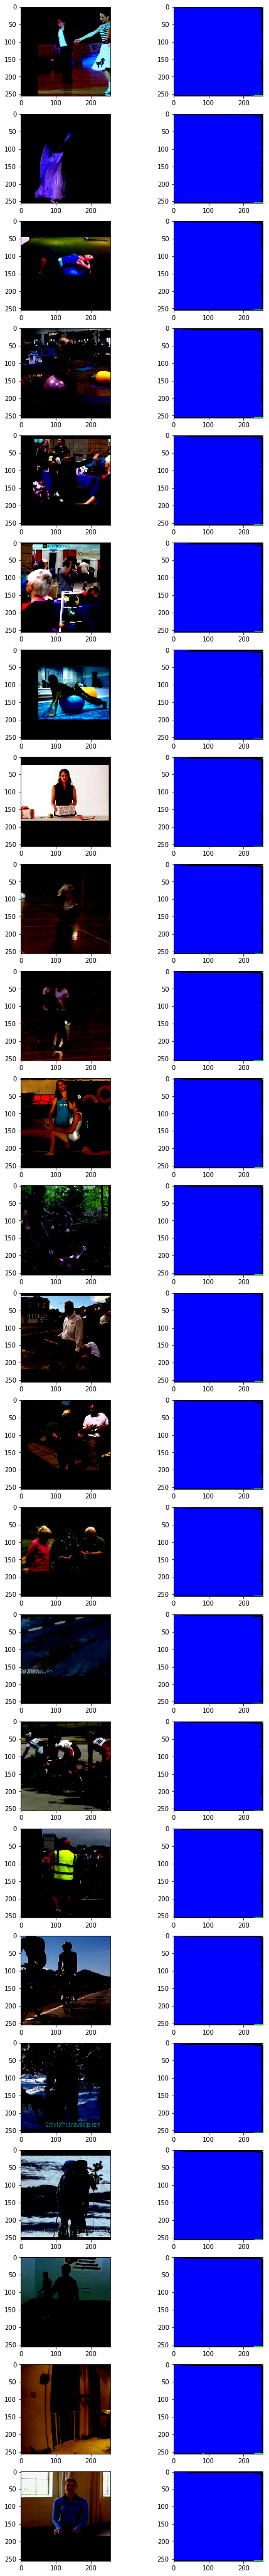

In [20]:
import matplotlib.pyplot as plt

n_cols = 2
n_rows = len(data['frame'])
fig = plt.figure(figsize=(8, 75))

print(len(data['frame']))
print(len(pred[0]))

i_img = 1
for i, data_img in enumerate(data['frame']):
    fig.add_subplot(n_rows, n_cols, i_img)
    plt.imshow(data_img)
    
    pred_img = pred[0][i]
    fig.add_subplot(n_rows, n_cols, i_img + 1)
    plt.imshow(pred_img)
    
    i_img += 2
    
plt.show()
